In [1]:
import os
import pandas as pd
import numpy as np
import requests


import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import pyeuropeana.apis as apis
import pyeuropeana.utils as utils

os.environ['EUROPEANA_API_KEY'] = 'api2demo'


In [56]:
# load watermark record and labeled_6999
record = pd.read_csv('/storage/data/watermark_record - Sheet1 (1).csv')
labeled = pd.read_csv('/storage/data/labeled_6999_report - labeled_6999_report.csv')
print(record.shape)
print(labeled.shape)

# get datasets with some in record
record = record.loc[record['watermarks'] == 'Some']
print(record.shape)

# get some and not reviewed datasets from labeled_6999
labeled = labeled.loc[labeled['watermarks'].apply(lambda x: x in ['Some',np.nan])]
labeled = labeled.head(200)
print(labeled.shape)

dataset_list = np.concatenate([record['dataset_name'].values,labeled['dataset_name'].values])
dataset_list = dataset_list.astype(str)

print(dataset_list.shape)
dataset_list = np.unique(dataset_list)
print(dataset_list.shape)

n_objects = 1000

df = pd.DataFrame()
for dataset in tqdm(dataset_list[:]):
    dataset_id = dataset.split('_')[0]
    response = apis.search(
        query = f'edm_datasetName:{dataset_id}_*',
        rows = n_objects,
        qf = 'TYPE:IMAGE',
        sort = 'random,europeana_id',
        )
    response = utils.search2df(response)

    df = pd.concat([df,response])


df.to_csv('/storage/data/sample_inference.csv',index = False)
print(df.shape)

(134, 8)
(451, 10)
(26, 8)
(200, 10)
(226,)
(191,)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [16:05<00:00,  5.06s/it]


(182600, 16)


In [2]:



#https://api.europeana.eu/record/v2/search.json?wskey=api2demo&query=*&rows=0&profile=facets&facet=edm_datasetName&f.edm_datasetName.facet.limit=10000

result = apis.search(
    query = '*',
    rows=0,
    profile = 'facets',
    facet = 'edm_datasetName&f.edm_datasetName.facet.limit=10000',
    )

df = pd.DataFrame(result['facets'][0]['fields'])

print(df)

dataset_df = df.loc[df['count']>=20]
#dataset_df = df.iloc[1000:1100]

print(dataset_df.shape)
print(dataset_df['count'].sum())

                                               label    count
0                          2058621_Ag_EU_LoCloud_NRA  2910176
1                    9200365_Ag_EU_TEL_a0142_Gallica  1191745
2     9200359_Ag_EU_TEL_a0601_Newspapers_Netherlands   747773
3                                   9200479_NLPoland   644682
4             9200384_Ag_EU_TEL_a0613_Newspapers_ONB   629498
...                                              ...      ...
2149                       856_ekultura_IlijaGultesa        1
2150                              88_ASINOU_1_Cyprus        1
2151                            895_APE_Landsarkivet        1
2152                            896_APE__Riksarkivet        1
2153           9200334_Ag_EU_TEL_a1223_EC1914_Slovak        1

[2154 rows x 2 columns]
(1941, 2)
62147757


In [39]:

# target datasets Ele 06 - 03

# https://api.europeana.eu/record/v2/search.json?wskey=api2demo&qf=TYPE:"IMAGE"&qf=COUNTRY:"Poland"&qf=COUNTRY:"Cyprus"&qf=COUNTRY:"Slovakia"&qf=COUNTRY:"Croatia"&qf=COUNTRY:"Bulgaria"&qf=COUNTRY:"Malta"&qf=COUNTRY:"Spain"&qf=COUNTRY:"Estonia"&query=contentTier:(3 OR 4)&rows=0&profile=facets&facet=edm_datasetName&f.edm_datasetName.facet.limit=10000


response = requests.get('https://api.europeana.eu/record/v2/search.json?wskey=api2demo&qf=TYPE:"IMAGE"&qf=COUNTRY:"Poland"&qf=COUNTRY:"Cyprus"&qf=COUNTRY:"Slovakia"&qf=COUNTRY:"Croatia"&qf=COUNTRY:"Bulgaria"&qf=COUNTRY:"Malta"&qf=COUNTRY:"Spain"&qf=COUNTRY:"Estonia"&query=contentTier:(3 OR 4)&rows=0&profile=facets&facet=edm_datasetName&f.edm_datasetName.facet.limit=10000')
response = response.json()
dataset_df = pd.DataFrame(response['facets'][0]['fields'])
dataset_df = dataset_df.loc[df['count']>=20]
dataset_df


,label,count
0,2024914_EuropeanaPhotography_Girona_1019,132899
1,2022719_Hispana_Galiciana_Arxivo,67261
2,2022717_Ag_ES_Hispana_Biblioteca_Nacional,30191
3,11617_Ag_EU_OpenUp!_UTNHM,26794
4,11624_Ag_OpenUp_GIT,24778
...,...,...
110,2058631_Ag_EU_LoCloud_PSRL-e,26
111,407_Cy_CUT_476,25
112,9200130_Ag_EU_TEL_a1013_Madrid,23
113,0940447_Ag_PL_bbc.mbp.org.pl,22


In [33]:
dataset_df['count'].mean()

3207.4055944055945

In [40]:
dataframe = pd.DataFrame()
for dataset_name in tqdm(dataset_df['label'].values[:]):
  result = apis.search(
      query = f'edm_datasetName:"{dataset_name}"',
      qf = 'TYPE:IMAGE', 
      rows = 1000
      )

  aggregator_list = [item['provider'][0] for item in result['items']]

  #print(aggregator_list)

  result = utils.search2df(result)

  #print(result.shape[0])
    
  if result is not None:
      result['dataset_name'] = dataset_name
      result['aggregator'] = aggregator_list
      
      dataframe = pd.concat([dataframe,result])

dataframe.to_csv('/storage/data/sample.csv',index = False)
dataframe.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [07:12<00:00,  3.76s/it]


(79548, 17)

(30270, 16)

Index(['path', 'no_watermark', 'watermark', 'prediction', 'absdiff',
       'europeana_id', 'uri', 'type', 'image_url', 'country', 'description',
       'title', 'creator', 'language', 'rights', 'provider', 'dataset_name',
       'concept', 'concept_lang', 'description_lang', 'title_lang'],
      dtype='object')
Number of inferences: 118
Number of datasets: 81


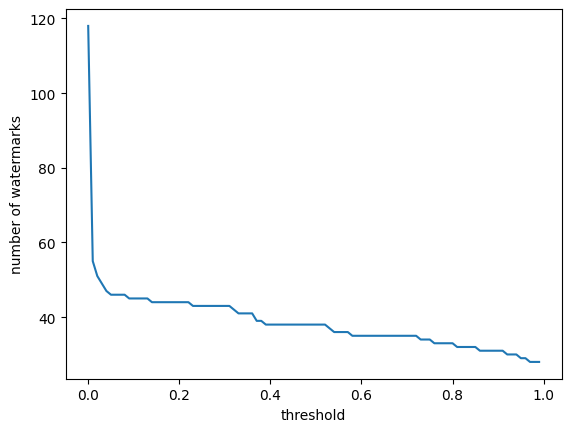

In [2]:
# Process inference


df = pd.read_csv('/storage/results/results_inference.csv')

print(df.columns)

df = df.drop([
    'path', 
    'type',
    'title_lang',
    'description_lang',
    'concept_lang',
    'concept',
    'creator',
    'title',
    'description',
    'language'
], axis=1)

print(f'Number of inferences: {df.shape[0]}')
print(f'Number of datasets: {len(df.dataset_name.unique())}')

n_watermarks_list = []
threshold_range = np.arange(0.0,1.0,0.01)
for threshold in threshold_range:
    df['prediction'] = df['watermark'].apply(lambda x: 'watermark' if x > threshold else 'no_watermark')
    watermark_df = df.loc[df['prediction'] == 'watermark']
    n_watermarks_list.append(watermark_df.shape[0])

img, ax = plt.subplots()
ax.plot(threshold_range,n_watermarks_list )
ax.set_xlabel('threshold')
ax.set_ylabel('number of watermarks')
plt.show()

In [13]:
df

,no_watermark,watermark,prediction,absdiff,europeana_id,uri,image_url,country,rights,provider,dataset_name
0,1.885456e-24,1.000000e+00,watermark,1.000000,/472/https___www_esbirky_cz_detail_6616191,http://data.europeana.eu/item/472/https___www_...,https://www.esbirky.cz/img.php?id=6616196,Czech Republic,http://creativecommons.org/licenses/by-nc-nd/4.0/,Historical Museum,472_NM_HM_Narodni_muzeum_Historicke_muzeum
1,6.375742e-16,1.000000e+00,watermark,1.000000,/91698/sm_photo_SuM_foto019487,http://data.europeana.eu/item/91698/sm_photo_S...,https://mm.dimu.org/image/032uK2eN2fPE?dimensi...,Sweden,http://creativecommons.org/licenses/by-nc/4.0/,Sundsvall Museum,91698_Ag_SE_SwedishNationalHeritage_SuM
2,5.648255e-14,1.000000e+00,watermark,1.000000,/470/https___www_esbirky_cz_detail_4209511,http://data.europeana.eu/item/470/https___www_...,https://www.esbirky.cz/img.php?id=4209515,Czech Republic,http://creativecommons.org/licenses/by/4.0/,National Museum - Virtual Museum,470_NM_VM_Narodni_muzeum_Virtualni_muzeum
3,1.000000e+00,1.115658e-13,no_watermark,1.000000,/519/catalognumber_mnhn_p_p05002531,http://data.europeana.eu/item/519/catalognumbe...,https://mediaphoto.mnhn.fr/media/1441382368080...,France,http://creativecommons.org/licenses/by/3.0/,Natural History Museum in Paris,519_OpenUp_MNHN_Pt3
4,1.621191e-13,1.000000e+00,watermark,1.000000,/916121/S_OLM_photo_OLM_2012_8_12920,http://data.europeana.eu/item/916121/S_OLM_pho...,https://mm.dimu.org/image/032wYWA7DP7c?dimensi...,Sweden,http://creativecommons.org/licenses/by-nc/4.0/,Örebro County Museum,916121_Ag_SE_s_olm
...,...,...,...,...,...,...,...,...,...,...,...
113,6.369238e-01,3.630762e-01,no_watermark,0.273848,/2026007/fabritiusweb_LinkToVubis_csp_DataBib_...,http://data.europeana.eu/item/2026007/fabritiu...,http://www.opac-fabritius.be/art-foto/mod/inte...,Belgium,http://rightsstatements.org/vocab/InC/1.0/,Royal Museums of Fine Arts of Belgium,2026007_Ag_EU_DCA_1017_Museums_Fine_Arts_Belgium
114,6.166007e-01,3.833994e-01,no_watermark,0.233201,/901/nbm_objekt_25014,http://data.europeana.eu/item/901/nbm_objekt_2...,https://samlingar.norrbottensmuseum.se/web/ima...,Sweden,http://creativecommons.org/publicdomain/zero/1.0/,Norrbottens Museum,901__Norrbottens_museum_2
115,4.253221e-01,5.746780e-01,watermark,0.149356,/334/Museu_ProvidedCHO_museum_digital_151862__...,http://data.europeana.eu/item/334/Museu_Provid...,https://ikmk.smb.museum/image/18208045/vs_exp.jpg,Germany,http://creativecommons.org/licenses/by-nc-sa/4.0/,"Numismatic Collection, Berlin State Museums",334_MUSEU_SPK
116,4.629229e-01,5.370771e-01,watermark,0.074154,/901/nbm_objekt_18278,http://data.europeana.eu/item/901/nbm_objekt_1...,https://samlingar.norrbottensmuseum.se/web/ima...,Sweden,http://creativecommons.org/publicdomain/zero/1.0/,Norrbottens Museum,901__Norrbottens_museum_2


In [22]:
# add aggregator

print('Adding aggregator...')
dataset_aggregator_dict = {}
unique_datasets = list(df.dataset_name.unique())
print(len(unique_datasets))
for dataset in unique_datasets[:]:
    dataset_id = dataset.split('_')[0]
    response = apis.search(
        query = f'edm_datasetName:{dataset_id}_*',
        rows = 1,
        qf = 'TYPE:IMAGE',
        sort = 'random,europeana_id',
        )
    
    #provider = response['items'][0]['dataProvider'][0]
    aggregator = response['items'][0]['provider'][0]
    dataset_aggregator_dict.update({dataset:aggregator})

df['aggregator'] = df['dataset_name'].apply(lambda x: dataset_aggregator_dict[x])
print('Finished adding aggregator')

81


                                         dataset_name    prediction  \
0                            07101_Ag_SK_EuropeanASNG  no_watermark   
1   08534_Ag_EU_ATHENA_International_Centre_For_In...  no_watermark   
2                                  09426_Ag_MT_Elocal  no_watermark   
3                                  09426_Ag_MT_Elocal     watermark   
4                                   11601_OpenUp_NHMV  no_watermark   
..                                                ...           ...   
82      91647_Ag_SE_SwedishNationalHeritage_smvk-mmcy     watermark   
83   91658_Ag_SE_SwedishNationalHeritage_malmo_objekt  no_watermark   
84            91698_Ag_SE_SwedishNationalHeritage_SuM     watermark   
85   9200196_Ag_EU_TEL_a1130b_EUCollections1418_Italy  no_watermark   
86                            92023_Ag_DK_kb.billeder  no_watermark   

                                             provider  \
0                             Slovak national gallery   
1   The International Center for 

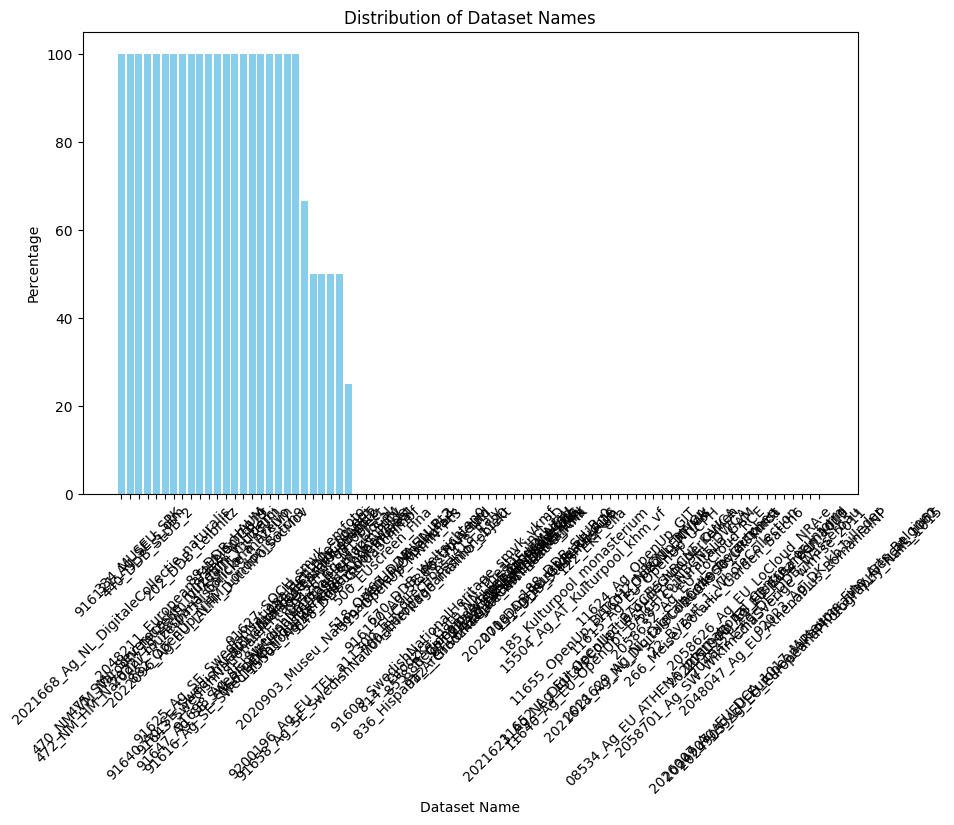

In [25]:
threshold = 0.5


df['prediction'] = df['watermark'].apply(lambda x: 'watermark' if x > threshold else 'no_watermark')

count_df = df.groupby(['dataset_name','prediction','provider','aggregator']).size().reset_index(name='counts')
count_df = count_df.rename(columns = {'counts':'n_images_processed'})
print(count_df)

response = requests.get('https://api.europeana.eu/record/v2/search.json?wskey=api2demo&query=*&rows=0&profile=facets&facet=edm_datasetName&f.edm_datasetName.facet.limit=10000')
response = response.json()
dataset_count_df = pd.DataFrame(response['facets'][0]['fields'])

per_dict = []
for dataset_name in count_df['dataset_name'].unique():
    _df = count_df.loc[count_df['dataset_name'] == dataset_name]

    provider = _df['provider'].values[0]
    aggregator = _df['aggregator'].values[0]

    n_no_watermark = _df['n_images_processed'].loc[_df['prediction'] == 'no_watermark']
    if not n_no_watermark.empty:
        n_no_watermark = n_no_watermark.sum()
    else:
        n_no_watermark = 0
        
    n_watermark = _df['n_images_processed'].loc[_df['prediction'] == 'watermark']
    if not n_watermark.empty:
        n_watermark = n_watermark.sum()
    else:
        n_watermark = 0

    n_images = n_watermark + n_no_watermark
    per_watermarks = round(100.0*n_watermark/n_images,2)

    per_dict.append({
        'dataset_name':dataset_name, 
        'provider':provider,
        'aggregator':aggregator,
        'percentage_watermarks':per_watermarks,
        'n_images_processed':n_images,
        'n_watermarks_detected':n_watermark
    })

per_df = pd.DataFrame(per_dict)   
per_df = per_df.sort_values(by='percentage_watermarks', ascending=False)  
print(per_df.shape)

def get_dataset_url(x):
    url = f"https://www.europeana.eu/en/search?query=edm_datasetName%3A{x.split('_')[0]}%2A&page=1&view=grid"
    return url

def get_number_items_dataset(x):
    return dataset_count_df['count'].loc[dataset_count_df['label'] == x].values[0]
    

per_df['url'] = per_df['dataset_name'].apply(get_dataset_url)
per_df['count_dataset'] = per_df['dataset_name'].apply(get_number_items_dataset)

columns = [
    'dataset_name',
    'provider',
    'aggregator',
    'url',
    'percentage_watermarks',
    'count_dataset',
    'n_images_processed',
    'n_watermarks_detected',
]

per_df.to_csv('/storage/results/inference_report.csv',index = False)


# Plot
plt.figure(figsize=(10, 6))
plt.bar(per_df['dataset_name'], per_df['percentage_watermarks'], color='skyblue')
plt.xlabel('Dataset Name')
plt.ylabel('Percentage')
plt.title('Distribution of Dataset Names')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.show()

In [20]:

threshold_percentage = 5.0

reduced_per_df = per_df.loc[per_df['percentage_watermarks'] > threshold_percentage]
print(reduced_per_df.shape)

output_df = pd.DataFrame()
filtered_names = []
for dataset_name in reduced_per_df['dataset_name'].unique():
    _df = df.loc[df['dataset_name'] == dataset_name]

    _df = _df.drop(columns = ['prediction','no_watermark','absdiff'])
    _df = _df.rename(columns = {'watermark':'confidence_score'})

    _df = _df.sort_values(by='confidence_score', ascending=False)  
    _df = _df.head(5)

    output_df = pd.concat([output_df,_df])

print(output_df.columns)
print(output_df.shape)

columns = ['europeana_id','confidence_score','dataset_name','provider','aggregator','uri','image_url','country','rights']
output_df = output_df[columns]



output_df.to_csv('/storage/data/watermark_report.csv',index = False)





(67, 8)
Index(['confidence_score', 'europeana_id', 'uri', 'image_url', 'country',
       'rights', 'provider', 'dataset_name', 'aggregator'],
      dtype='object')
(335, 9)


In [11]:
output_df

,europeana_id,confidence_score,dataset_name,provider,uri,image_url,country,rights
3,/2022713/oai_rebae_mcu_es_183695,1.000000,2022713_Ag_ES_Hispana_ccbae,Collective Catalog of the Library Network of t...,http://data.europeana.eu/item/2022713/oai_reba...,http://www.mcu.es/ccbae/i18n/catalogo_imagenes...,Spain,http://creativecommons.org/publicdomain/mark/1.0/
297,/2022713/oai_rebae_mcu_es_183868,1.000000,2022713_Ag_ES_Hispana_ccbae,Collective Catalog of the Library Network of t...,http://data.europeana.eu/item/2022713/oai_reba...,http://www.mcu.es/ccbae/i18n/catalogo_imagenes...,Spain,http://creativecommons.org/publicdomain/mark/1.0/
457,/2022713/oai_rebae_mcu_es_183770,1.000000,2022713_Ag_ES_Hispana_ccbae,Collective Catalog of the Library Network of t...,http://data.europeana.eu/item/2022713/oai_reba...,http://www.mcu.es/ccbae/i18n/catalogo_imagenes...,Spain,http://creativecommons.org/publicdomain/mark/1.0/
453,/2022713/oai_rebae_mcu_es_183936,1.000000,2022713_Ag_ES_Hispana_ccbae,Collective Catalog of the Library Network of t...,http://data.europeana.eu/item/2022713/oai_reba...,http://www.mcu.es/ccbae/i18n/catalogo_imagenes...,Spain,http://creativecommons.org/publicdomain/mark/1.0/
400,/2022713/oai_rebae_mcu_es_184071,1.000000,2022713_Ag_ES_Hispana_ccbae,Collective Catalog of the Library Network of t...,http://data.europeana.eu/item/2022713/oai_reba...,http://www.mcu.es/ccbae/i18n/catalogo_imagenes...,Spain,http://creativecommons.org/publicdomain/mark/1.0/
...,...,...,...,...,...,...,...,...
2393,/912/https___biblioteka_teatrnn_pl_dlibra_publ...,0.999996,912__GrodzkaGate_NNTheatre_JARK,Grodzka Gate – NN Theatre,http://data.europeana.eu/item/912/https___bibl...,https://biblioteka.teatrnn.pl/Content/88598,Poland,http://rightsstatements.org/vocab/InC/1.0/
3571,/912/https___biblioteka_teatrnn_pl_dlibra_publ...,0.999988,912__GrodzkaGate_NNTheatre_JARK,Grodzka Gate – NN Theatre,http://data.europeana.eu/item/912/https___bibl...,https://biblioteka.teatrnn.pl/Content/88588,Poland,http://rightsstatements.org/vocab/InC/1.0/
4061,/912/https___biblioteka_teatrnn_pl_dlibra_publ...,0.999982,912__GrodzkaGate_NNTheatre_JARK,Grodzka Gate – NN Theatre,http://data.europeana.eu/item/912/https___bibl...,https://biblioteka.teatrnn.pl/Content/99883,Poland,http://rightsstatements.org/vocab/InC/1.0/
5536,/912/https___biblioteka_teatrnn_pl_dlibra_publ...,0.999956,912__GrodzkaGate_NNTheatre_JARK,Grodzka Gate – NN Theatre,http://data.europeana.eu/item/912/https___bibl...,https://biblioteka.teatrnn.pl/Content/99672,Poland,http://rightsstatements.org/vocab/InC/1.0/
